This notebook trains a binary classifier on a dataset which contains movie reviews which are labelled as containing either *positive* or *negative* sentiment towards the movie.

First we will install *sklearn* which we will be using to do the machine learning.

In [41]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Next we will install the dataset. We will use the IMDB sentiment analysis dataset available from the [huggingface datasets library](https://huggingface.co/datasets/imdb) and described in [Maas et al. 2011](https://aclanthology.org/P11-1015.pdf).

In [42]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


Now let's load the IMDB training set. We will print out the last instance.

In [43]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")['train']
print(imdb_dataset[-1])

{'text': 'The story centers around Barry McKenzie who must go to England if he wishes to claim his inheritance. Being about the grossest Aussie shearer ever to set foot outside this great Nation of ours there is something of a culture clash and much fun and games ensue. The songs of Barry McKenzie(Barry Crocker) are highlights.', 'label': 1}


Let's convert the training data into the format expected by scikit-learn - a list of input vectors (documents) and a list of associated output labels.

In [44]:
train_data = []
train_data_labels = []
for item in imdb_dataset:
  train_data.append(item['text'])
  train_data_labels.append(item['label'])
print(train_data[-1])
print(train_data_labels[-1])

The story centers around Barry McKenzie who must go to England if he wishes to claim his inheritance. Being about the grossest Aussie shearer ever to set foot outside this great Nation of ours there is something of a culture clash and much fun and games ensue. The songs of Barry McKenzie(Barry Crocker) are highlights.
1


We'll use the CountVectorizer class to extract the words in each review as the features the algorithm will learn from. Each document is represented as a 200 dimension vector of word counts. Only the 200 most frequent words are used in this version.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word',max_features=5000,lowercase=True)
features = vectorizer.fit_transform(train_data).toarray()

As a sanity check, let's check we have a 2-d array where each row is one of the 25,000 instances and each column is one of 200 words. Print out the words that will be used for classification.

In [46]:
print(features.shape)
print(vectorizer.get_feature_names_out())

(25000, 5000)
['00' '000' '10' ... 'zombie' 'zombies' 'zone']


Split the data into a training and validation (dev) set. We'll use the validation set to test our model. We'll use 75% of the data for training and 25% for testing.

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features,train_data_labels,train_size=0.75,random_state=123)

We will use Multinomial Naive Bayes to do the classification. Create the model.

In [54]:
from sklearn.ensemble import RandomForestClassifier
feature_names = [f"feature {i}" for i in range(features.shape[1])]
model = RandomForestClassifier(random_state=42)

Train the model.

In [55]:
model = model.fit(X=X_train,y=y_train)

In [60]:
feature_importances = model.feature_importances_
top_50_indices = feature_importances.argsort()[-50:][::-1]
top_50_feature_names = [feature_names[i] for i in top_50_indices]

Test the model on the validation set.

In [56]:
y_pred = model.predict(X_val)

Now let's calculate the accuracy of the model's predictions on the validation set.

In [57]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val,y_pred))

0.832


In [68]:
import time

import numpy as np

start_time = time.time()
importances = top_50_indices
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.040 seconds


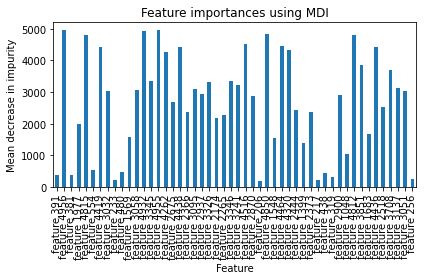

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have forest_importances, top_50_feature_names, and std ready
forest_importances = pd.Series(importances, index=top_50_feature_names)

fig, ax = plt.subplots()
forest_importances.plot(kind='bar', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("Feature")
fig.tight_layout()
plt.show()


The code here is from scikit learn where it tests the mean and standard deviation and ranks them based on there impurity decrease within each tree. It produces a graph showing the mean decrease in impurity for the top 50 most important features